# Artificial Neural Network Assignment 1 - Multilayer Perceptron (MLP)

NAME: DAVID ADESHINA ARUNGBEMI

ID NUMBER: 191203012

DEPARTMENT: COMPUTER ENGINEERING

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA = pd.read_csv("IRIS.csv")

In [3]:
DATA.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
#classes
DATA["species"].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
# features
DATA.columns[:-1]

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')

## Preprocessing

### Label Encoding

In [6]:
label_encoding = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
DATA['species'] = DATA['species'].map(label_encoding)

In [7]:
DATA["species"].unique()

array([0, 1, 2])

### Shuffling

In [8]:
#SHUFFLE DATA
DATA = DATA.sample(frac=1, random_state=32)

In [9]:
#number of rows
len(DATA)

150

### Train-Test Split

In [10]:
# SEPARATING TARGET FROM FEATURES
X = DATA.drop(columns="species")
y = DATA["species"]

In [11]:
train_size = 0.7

In [12]:
X_train = X[:int(len(X) * train_size)]
y_train = y[:int(len(y) * train_size)]

In [13]:
X_test = X[int(len(X) * train_size):]
y_test = y[int(len(y) * train_size):]

In [14]:
#length of train
print(f'Train size: {len(X_train)}')

Train size: 105


In [15]:
#length of test
print(f'Test size: {len(X_test)}')

Test size: 45


### Normalisation

In [16]:
#Before Normalisation
X_train.head()

,sepal_length,sepal_width,petal_length,petal_width
55,5.7,2.8,4.5,1.3
22,4.6,3.6,1.0,0.2
26,5.0,3.4,1.6,0.4
56,6.3,3.3,4.7,1.6
134,6.1,2.6,5.6,1.4


In [17]:
X_test.head()

,sepal_length,sepal_width,petal_length,petal_width
136,6.3,3.4,5.6,2.4
74,6.4,2.9,4.3,1.3
101,5.8,2.7,5.1,1.9
50,7.0,3.2,4.7,1.4
83,6.0,2.7,5.1,1.6


In [18]:
mean = []
std = []
def z_score(X: pd.DataFrame):
    global mean
    global std
    for feature in X.columns:
         mean.append(X[feature].mean())
         std.append(X[feature].std())
         X.loc[:,feature] = (X[feature] - mean[-1]) / std[-1]

def apply_z_score(X: pd.DataFrame):
    global mean
    global std
    count = 0
    for feature in X.columns:
        X.loc[:,feature] = (X[feature] - mean[count]) / std[count]
        count += 1

In [19]:
min_x = []
max_x = []

def min_max(X: pd.DataFrame):
    global min_x
    global max_x
    for feature in X.columns:
        min_x.append(X[feature].min())
        max_x.append(X[feature].max())
        X.loc[:,feature] = (X[feature] - min_x[-1]) / (max_x[-1] - min_x[-1])

def apply_min_max(X: pd.DataFrame):
    global min_x
    global max_x
    count = 0
    for feature in X.columns:
        X.loc[:,feature] = (X[feature] - min_x[count]) / (max_x[count] - min_x[count])
        count += 1

In [20]:
z_score(X_train)

In [21]:
apply_z_score(X_test)

In [22]:
# after normalisation
X_train.head()

,sepal_length,sepal_width,petal_length,petal_width
55,-0.137961,-0.626521,0.474915,0.187549
22,-1.465832,1.093340,-1.449355,-1.219069
26,-0.982969,0.663375,-1.119480,-0.963320
56,0.586333,0.448392,0.584873,0.571172
134,0.344902,-1.056486,1.079686,0.315423


In [23]:
X_test.head()

,sepal_length,sepal_width,petal_length,petal_width
136,0.586333,0.663375,1.079686,1.594167
74,0.707048,-0.411538,0.364957,0.187549
101,-0.017245,-0.841503,0.804790,0.954795
50,1.431341,0.233410,0.584873,0.315423
83,0.224186,-0.841503,0.804790,0.571172


## MODEL

### NN Architecture

1. I decided to go further by creating a simple framework for any creating MLP model network.
2. Utilised a bias per neuron approach instead of the bias per layer as I found it easier to code and also has better flexibility
3. Loss functions: mse and cross entropy
4. Activation: ReLu, Sigmoid, and Linear(no activation)

In [24]:
from typing import Tuple, List

In [25]:
def Metrics(metric: str,y_true, y_prob_distr_pred) -> float:
    assert isinstance(y_true, np.ndarray), 'y_true must be type numpy'
    isinstance(y_prob_distr_pred, np.ndarray), 'y_prob_distr_pred must be type numpy'
    y_prob_distr_pred[0].ndim == 2, 'prob distribution of elements in y_prob_distr_pred must be 2D'
    
    if metric == 'accuracy':
        encoded = np.array([np.argmax(y_prob.T[0]) for y_prob in y_prob_distr_pred])
        correct_pred = sum(encoded == y_true)
        return correct_pred/len(y_true)

In [26]:
def Activation(fn: str, X, dfn: bool):
    assert isinstance(X, np.ndarray), 'X Should be a numpy array'
    result = None
    if fn == 'sigmoid':
        if dfn: #if derivative
            result = lambda X: np.exp(-X) / ((1 + np.exp(-X)) ** 2)
        else:
            result = lambda X : 1 / (1 + np.exp(-X))
        
    elif fn == 'relu':
        if dfn: #if derivative
            result = lambda X : np.where(X > 0, 1, 0)
        else:
            result = lambda X : np.maximum(0, X) 

    elif fn == 'softmax':
        if dfn: #if derivative
            exp_X = np.exp(X)
            a = exp_X / np.sum(exp_X)
            result = lambda a :  a * (1 - a)
        else:
            exp_X = np.exp(X)
            result = lambda X : exp_X / np.sum(exp_X)

    elif fn == 'linear':
         result = lambda X : X
            
    else:
        raise ConditionNotMetError("Invalid activation!")

    return result(X)

In [27]:
def Loss_Fn(fn: str, y_true, y_pred, dfn: bool): 
    assert isinstance(y_true, np.ndarray), 'y_true Should be a numpy array'
    assert isinstance(y_pred, np.ndarray), 'y_pred Should be a numpy array'
    result = None
    
    if fn == 'mse':
        if dfn: #if derivative
            return -(y_true - y_pred)
        else:
            return 0.5 * np.square(y_true - y_pred)

    elif fn == 'cross_entropy':
        true_distr = np.array([np.array([0]) if i != y_true[0][0] else np.array([1]) 
                               for i in range(y_pred.shape[0])])
        if dfn: #if derivative
            return -true_distr / y_pred
        else:
            return -np.sum(true_distr * np.log(y_pred))
        
    else:
        raise ConditionNotMetError("Invalid cost!")

In [28]:
class MLP:
    def __init__(self, layers: tuple, lr: float, activation: str, l_o_activation: str, cost: str, random_seed: int = 42, weight_range: Tuple[float, float] = (-0.1 , 0.1)):
        np.random.seed(random_seed)
        self.counter  = 0
        min_w = weight_range[0]
        max_w = weight_range[1]
        self.lr = lr
        self.activation = activation
        self.l_o_activation = l_o_activation
        self.cost = cost
        self.loss_history = []
        self.weights = [np.random.uniform(min_w, max_w, 
                                          size=(layers[i],layers[i-1]))
                        for i in range(1,len(layers))]
        
        self.bias = [np.random.uniform(min_w, max_w, size=(layers[i], 1))
                    for i in range(1,len(layers))]

    def forward(self, X: np.ndarray):
        assert isinstance(X, np.ndarray), 'Should be a numpy array'
        assert X.ndim == 2, 'X should be 2 dimension'
        Z = X.T.copy()
        self.layer_history = [[None, Z]] 
        for i in range(len(self.weights)-1): #to multiply through weights in each hidden layer
            layer_store = [] 
            W = self.weights[i]
            
            Z = np.dot(W, Z) + self.bias[i] #matrix multiplication + bias
            layer_store.append(Z)
            Z = Activation(self.activation, Z, False) #applying activation function
            layer_store.append(Z)

            self.layer_history.append(layer_store) #to store outputs in each layer later for backpropagation

        # output layer
        layer_store = []
        W = self.weights[-1]
        Z = np.dot(W, Z) + self.bias[-1]
        layer_store.append(Z)
        Z = Activation(self.l_o_activation, Z, False)
        layer_store.append(Z)
        self.layer_history.append(layer_store)
        
        return Z

    def backward(self, y_true: np.ndarray):
        assert isinstance(y_true, np.ndarray)
        assert y_true.ndim == 2, 'y_true should be 2 dimension'
        weights_ = self.weights.copy()
        Z = self.layer_history[-1][0] #before activation
        y_pred = self.layer_history[-1][1] #after activation

        dC_dZ = None
        if self.l_o_activation != 'softmax':
            dC_dA = Loss_Fn(self.cost, y_true, y_pred, True)
            dA_dZ = Activation(self.l_o_activation, Z, True)
            dC_dZ = dC_dA * dA_dZ 

        else:
            true_distr = np.array([np.array([0]) if i != y_true[0][0] else np.array([1]) 
                               for i in range(Z.shape[0])])
            
            dC_dZ = Activation(self.l_o_activation, Z, False) - true_distr
            # print(dC_dZ, true_distr, sep ='\n\n')
            
        dZ_dW = self.layer_history[-2][1]
        dC_dW = np.dot(dC_dZ, dZ_dW.T)
        dC_dB = dC_dZ

        self.weights[-1] -= dC_dW * self.lr #update weight at layer
        self.bias[-1] -= dC_dB  * self.lr #update bias at layer

        if len(weights_) != 1:
            self.chain_rule(np.dot(dC_dZ.T, weights_[-1]), weights_)
    
    def chain_rule(self, dC_dA, weights_):
        self.layer_history.pop()
        weights_.pop();
        for _ in range(len(weights_)):
            Z = self.layer_history[-1][0]
    
            dA_dZ = Activation(self.activation, Z, True)
            dZ_dW = self.layer_history[-2][1]
    
            dC_dZ = dC_dA.T * dA_dZ
            dC_dW = np.dot(dC_dZ, dZ_dW.T)
            dC_dB = dC_dZ
    
            self.weights[len(weights_) - 1] -= dC_dW * self.lr #update weight at layer
            self.bias[len(weights_) - 1] -= dC_dB  * self.lr #update bias at layer
            dC_dA = np.dot(dC_dZ.T, weights_[-1])

            self.layer_history.pop()
            weights_.pop();

    def train(self, Epochs: int,X, y_true):
        assert isinstance(X, np.ndarray), 'Should be a numpy array'
        assert X.ndim == 2, 'X should be 2 dimension'
        for epoch in range(Epochs):
            loss = None
            for i in range(X.shape[0]):
                x = np.expand_dims(X[i], axis = 0)
                y = np.array([[y_true[i]]])
                pred = self.forward(x)
                self.backward(y)
                loss = Loss_Fn(self.cost, y, pred, False) # False -> no derivatives

            self.loss_history.append(loss)

    def predict(self,X):
        assert isinstance(X, np.ndarray), 'Should be a numpy array'
        assert X.ndim == 2, 'X should be 2 dimension'
        predictions = []
        
        for i in range(X.shape[0]): #go through the samples of data
            x = np.expand_dims(X[i], axis = 0)
            predictions.append(self.forward(x))

        return np.array(predictions)

### Testing NN Model

$$ f(x) = 2^x, x ∈ [0, ∞) $$

In [29]:
a = np.array([
    [2,0],
    [2,1],
    [2,2],
    [2,3],
    [2,4],
    [2,5]
    ]
)

In [30]:
b = np.array([
    1,
    2,
    4,
    8,
    16,
    32]
)

In [31]:
nn = MLP((2,5,5,1), 1e-3, 'relu', 'relu', 'mse', 0, (-1,1))

In [32]:
nn.train(2, a, b)

In [33]:
nn.forward(np.array(a))

array([[ 0.87853164,  2.68206577,  6.35129734, 10.26206205, 14.17282676,
        17.97540479]])

### Testing Model with Iris Dataset

In [34]:
nn = MLP(
        layers = (4,5,5,3), 
         lr = 1e-3, 
         activation = 'relu', 
         l_o_activation = 'softmax', 
         cost = 'cross_entropy', 
         random_seed = 42, 
         weight_range = (-0.1, 0.1)
        )

In [35]:
train_acc = []
test_acc = []
for epochs in range(100, 1001, 100):
    nn.train(epochs, X_train.values, y_train.values)
    train_acc.append(Metrics('accuracy', y_train.values, nn.predict(X_train.values)))
    test_acc.append(Metrics('accuracy', y_test.values, nn.predict(X_test.values)))

In [36]:
# nn.train(1000, X_train.values, y_train.values)

In [37]:
train_prediction = nn.predict(X_train.values)

In [38]:
test_prediction = nn.predict(X_test.values)

#### Train Accuracy

In [39]:
train_accuracy = Metrics('accuracy', y_train.values, train_prediction)
train_accuracy

1.0

#### Test Accuracy

In [40]:
test_accuracy = Metrics('accuracy', y_test.values, test_prediction)
test_accuracy

0.9333333333333333

#### Accuracy (Entire Data)

In [41]:
features = X.copy() #create a copy of X

In [42]:
z_score(features) #perform z-score normalisation

In [43]:
nn.train(1000, features.values, y.values)

In [44]:
pred = nn.predict(features.values)

In [45]:
Metrics('accuracy', y.values, pred)

0.9866666666666667

#### Accuracy vs Epoch Plot

In [46]:
import matplotlib.pyplot as plt

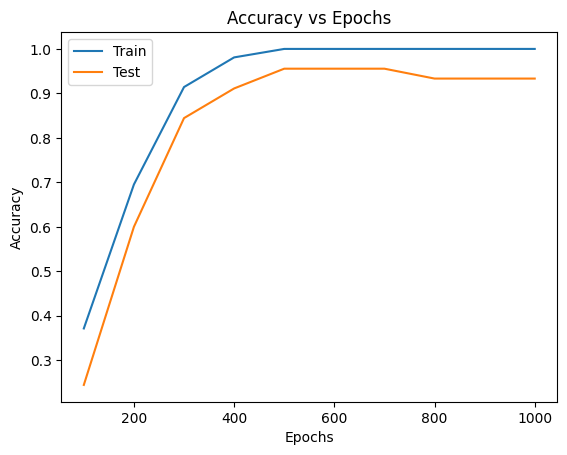

In [47]:
plt.plot(list(range(100, 1001, 100)), train_acc, label = 'Train')
plt.plot(list(range(100, 1001, 100)), test_acc, label = 'Test')
plt.legend()
plt.xlabel('Epochs')
# plt.xticks(range(100, 1001, 100))
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs');

### What makes my work different from others?

1. Created a simple mlp framework instead, can perform regression and classification
2. Activation function: ReLU, Sigmoid, Softmax
3. Loss: Cross Entropy, MSE
4. Code organisation
5. Reproducable results using numpy's random seed to ensure initial weights are always the same regardless of how many times its run.
6. Reproducable accuracy
7. Just in case: I used a 70/30 train-test split